In [1]:
!pip install transformers

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.transform = transform
        self.image_list = os.listdir(root_dir)
        self.captions = self.load_captions()

    def __len__(self):
        return len(self.image_list)

    def load_captions(self):
        with open(self.caption_file, 'r') as file:
            captions = file.readlines()
        return captions

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert("RGB")

        caption = self.captions[idx].strip()  # Assuming each line in the caption file corresponds to an image

        if self.transform:
            image = self.transform(image)

        return image, caption

# Set the path to your dataset
dataset_path = "Images"
caption_file = "captions.txt"

# Define image transformations (you may need to adjust based on model requirements)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Add more transforms if needed
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_dir=dataset_path, caption_file=caption_file, transform=transform)

# Set batch size and create a data loader
batch_size = 16
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import BlipForConditionalGeneration, AutoTokenizer
from torchvision import transforms
from PIL import Image

# Instantiate the model and auto tokenizer
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10

# Create the optimizer AFTER moving the model to GPU
optimizer = Adam(model.parameters(), lr=0.001)
accumulation_steps = 4
# Training loop
for epoch in range(num_epochs):
    accumulated_loss = 0
    for i, (images, captions) in enumerate(data_loader):
        # Assuming the model takes images and captions as inputs
        # Make sure to reshape images if needed and convert them to tensor
        pixel_values = torch.tensor(images, dtype=torch.float32).to(device)

        # Tokenize captions and convert them to tensor
        inputs = tokenizer(captions, return_tensors="pt", truncation=True, padding=True)

        # Assuming 'input_ids' and 'attention_mask' are the relevant keys in 'inputs'
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}

        # Pass the inputs to the model
        outputs = model(pixel_values=pixel_values, **inputs, labels=inputs["input_ids"])

        loss = outputs.loss

        # Accumulate gradients
        loss.backward()

        # Perform optimization step after 'accumulation_steps' batches
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        accumulated_loss += loss.item()

        # Free unused GPU memory
        del pixel_values, inputs, outputs, loss
        torch.cuda.empty_cache()

    # Print or log the accumulated loss for monitoring during training
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {accumulated_loss / len(data_loader)}')


<ipython-input-6-81bc5e6637a9>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(images, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 5.890741402923825
Epoch [2/10], Loss: 5.647582007962253
Epoch [3/10], Loss: 5.627255964656121
Epoch [4/10], Loss: 5.639786966233386
Epoch [5/10], Loss: 5.634341469866485
Epoch [6/10], Loss: 5.633193677593126
Epoch [7/10], Loss: 5.622065276496495
Epoch [8/10], Loss: 5.615226267825944
Epoch [9/10], Loss: 5.609417623210802
Epoch [10/10], Loss: 5.610821116111967


In [7]:
# Save the trained model
torch.save(model.state_dict(), 'blip_trained_model.pth')

Blip trained -2

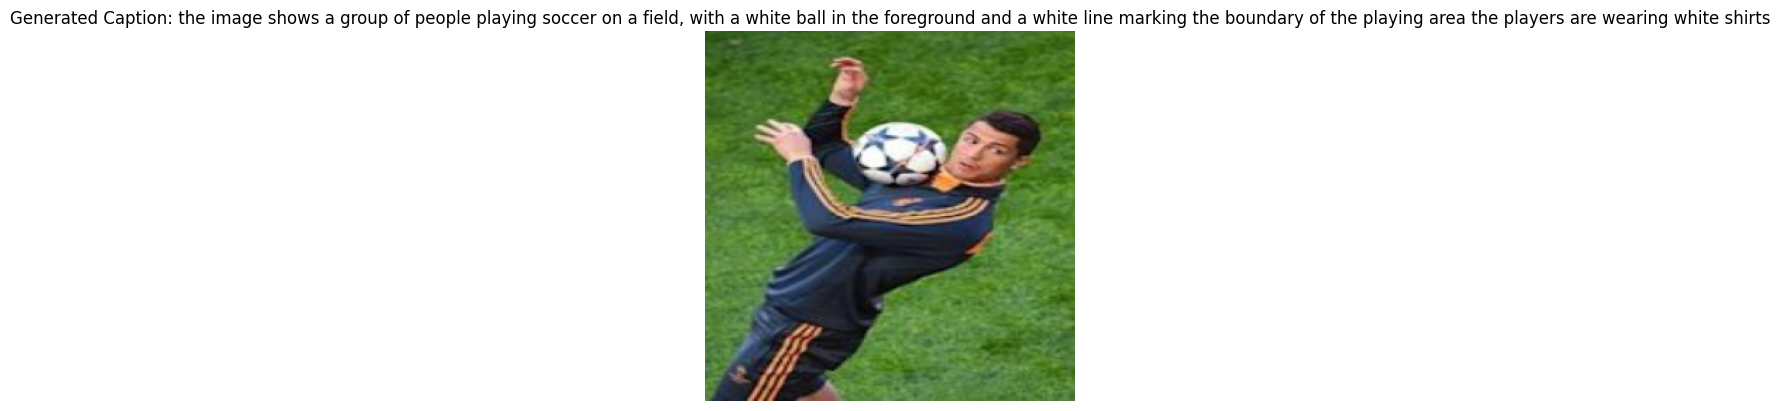

In [11]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "cris.jpeg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()


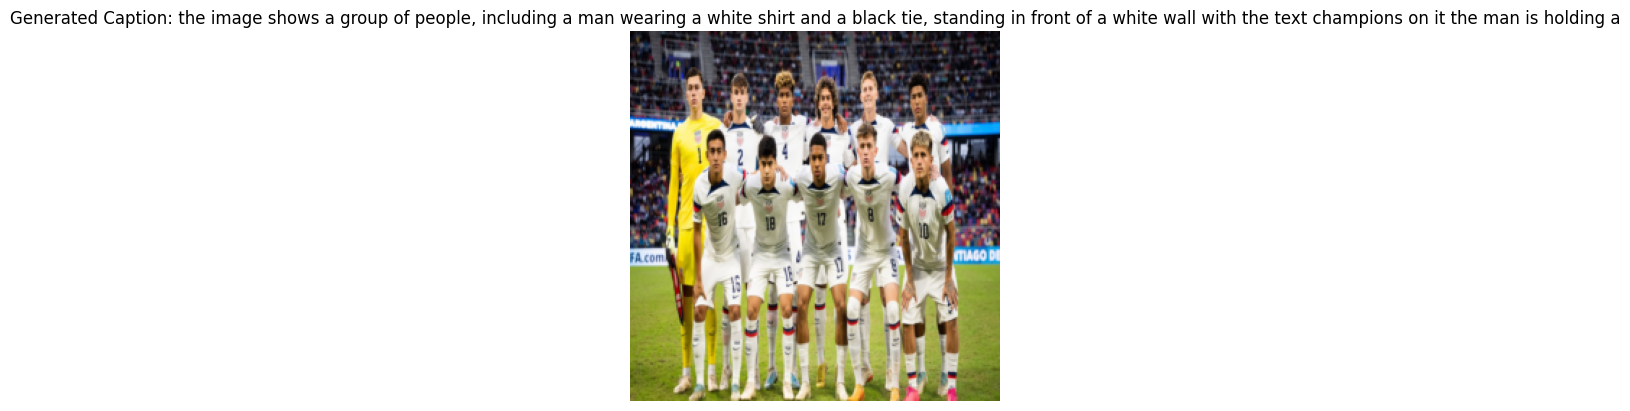

In [13]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "image.jpg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()


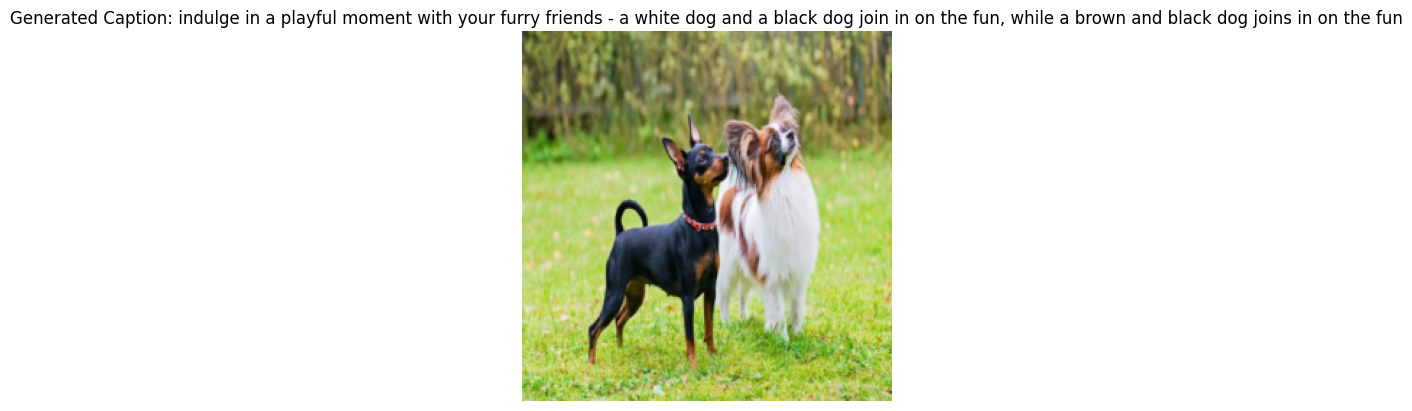

In [14]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "/content/two dogs looking into sky while playing in a park.jpg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()


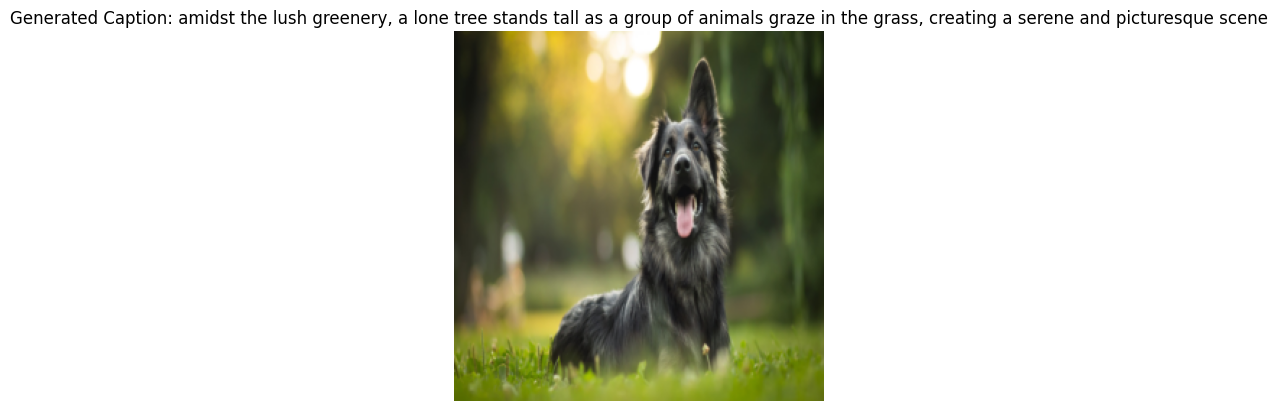

In [15]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "/content/a black dog smiling while sitting in a park.jpg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()


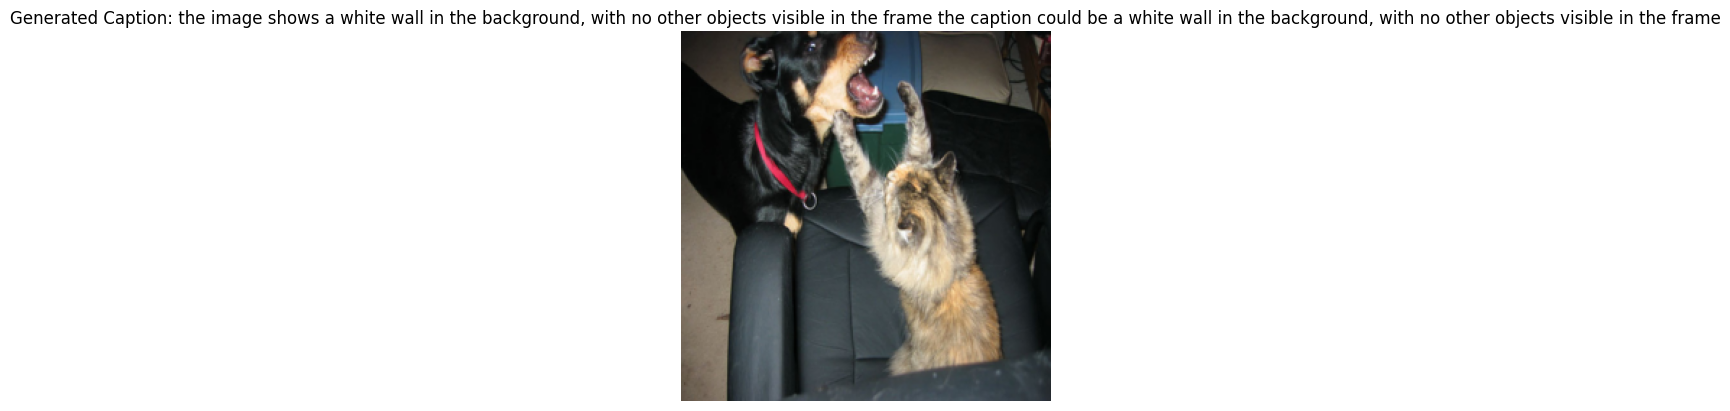

In [16]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "/content/97406261_5eea044056.jpg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()


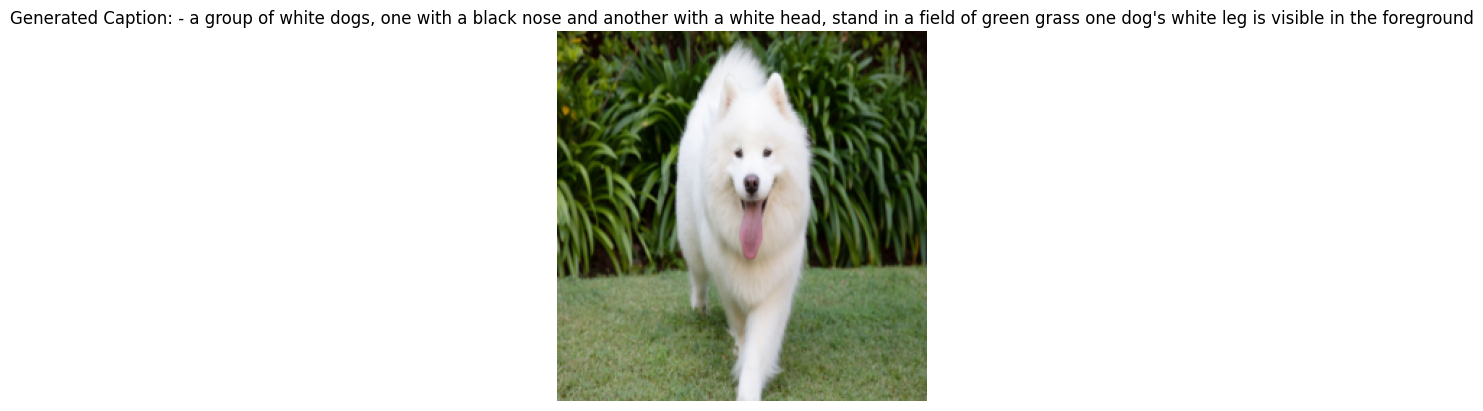

In [17]:
import torch
from PIL import Image
from transformers import BlipForConditionalGeneration, AutoTokenizer
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the trained model
model_path = "blip_trained_model.pth"
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")
tokenizer = AutoTokenizer.from_pretrained("noamrot/FuseCap")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Generate caption
    output = model.generate(pixel_values=image)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)

    return image, caption

# Test the model on an example image
example_image_path = "/content/white fluffy playing in the park.jpg"
image, caption = generate_caption(example_image_path)

# Display the image and generated caption
plt.imshow(transforms.ToPILImage()(image.squeeze(0).cpu()))
plt.title("Generated Caption: " + caption)
plt.axis("off")
plt.show()
